In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fresnel_coro_2dm as fresnel
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils

from apra_pop_models.imshows import *

pupil_diam = 9.5*u.mm
wavelength_c = 650e-9*u.m

# reload(utils)
# wfe = utils.generate_wfe(diam=pupil_diam, npix=512, oversample=1,
#                          opd_index=2.5, amp_index=2.5, 
#                          opd_seed=12, amp_seed=34,
#                          opd_rms=15*u.nm, amp_rms=0.05, 
#                          wavelength=wavelength_c)

# TELE_WFE = poppy.ArrayOpticalElement(name='WFE', 
#                                      transmission=xp.abs(wfe),
#                                      opd=xp.angle(wfe)*wavelength_c.to_value(u.m)/(2*np.pi), 
#                                      pixelscale=pupil_diam/(512*u.pix),)

# wfe_mask = TELE_WFE.amplitude>0
# rms_amp = xp.sqrt(xp.mean(TELE_WFE.amplitude[wfe_mask]**2))
# rms_opd = xp.sqrt(xp.mean(TELE_WFE.opd[wfe_mask]**2))
# imshow2(TELE_WFE.amplitude, TELE_WFE.opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


In [38]:
coro.lyot_pupil_diam/2

<Quantity 3.8 mm>

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


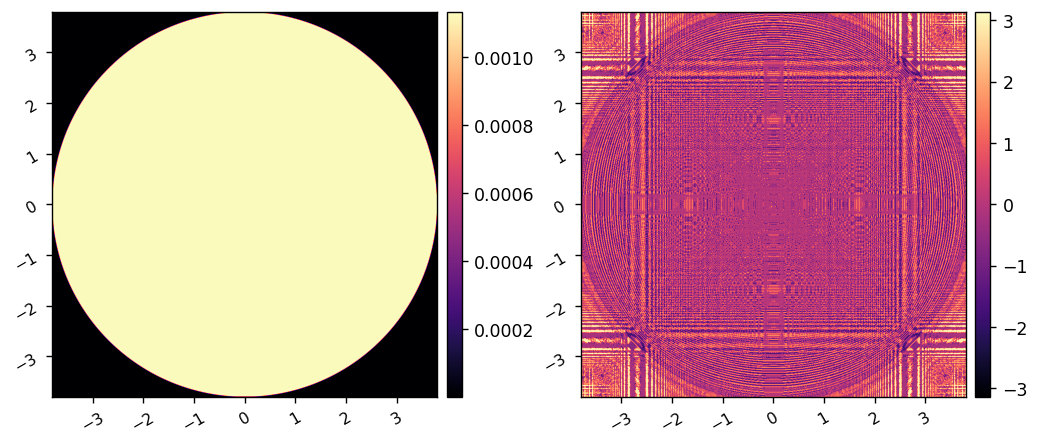

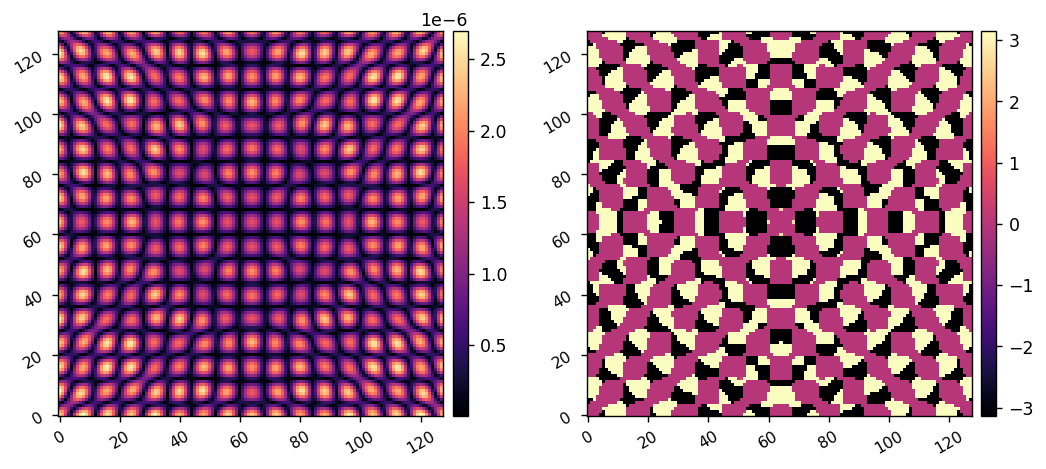

In [36]:
reload(fresnel)
poppy_log.disabled = True

coro = fresnel.CORO()
# imshow2(coro.APERTURE.amplitude, coro.LYOT.amplitude, 
#         pxscl1=coro.APERTURE.pixelscale.to(u.mm/u.pix), pxscl2=coro.LYOT.pixelscale.to(u.mm/u.pix))

fpwf = coro.calc_psf()
imshow2(xp.abs(fpwf), xp.angle(fpwf))

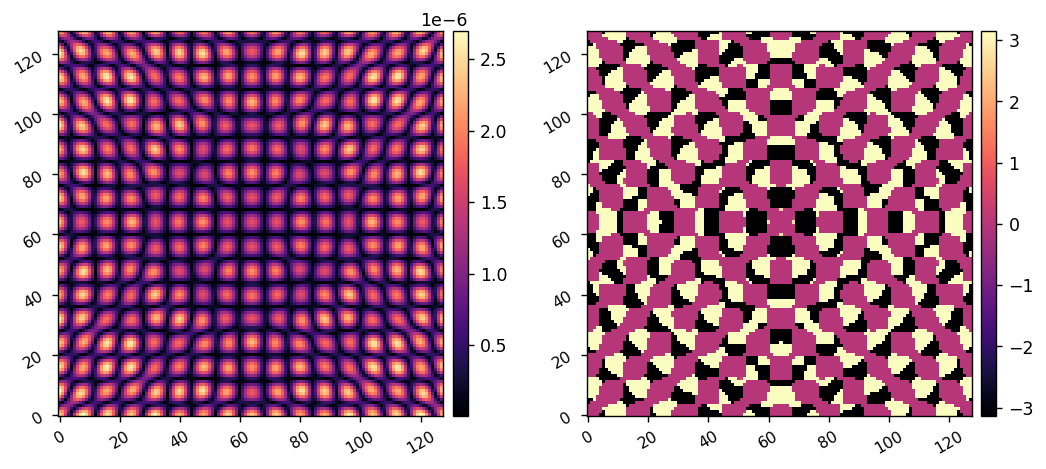

In [33]:
imshow2(xp.abs(fpwf), xp.angle(fpwf))


In [3]:
fpm_wf.amplitude.shape

(2048, 2048)

In [26]:
lyot_wfarr = poppy.accel_math.fft_2d(fpm_wf.wavefront, fftshift=True, forward=False)
imshow2(xp.abs(lyot_wfarr), xp.angle(lyot_wfarr), npix=1000)


AttributeError: 'ndarray' object has no attribute 'wavefront'

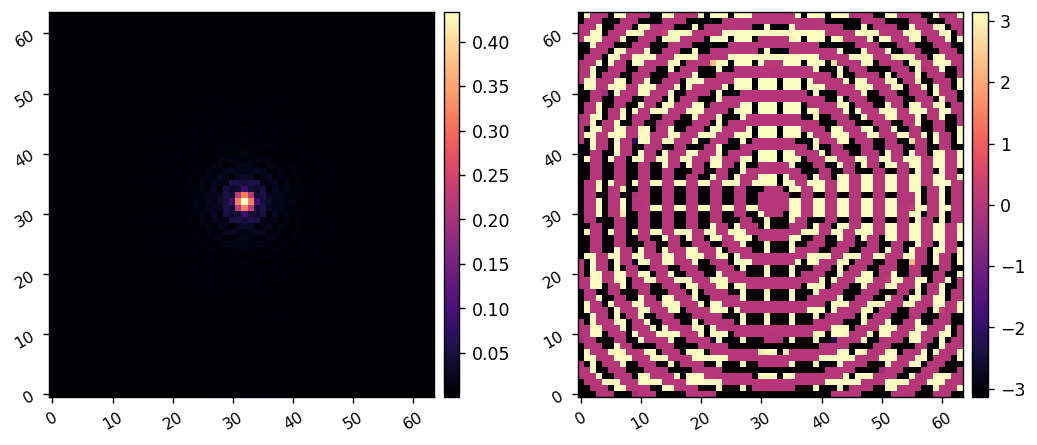

In [6]:
imshow2(fpm_wf.amplitude, fpm_wf.phase, npix=64)

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


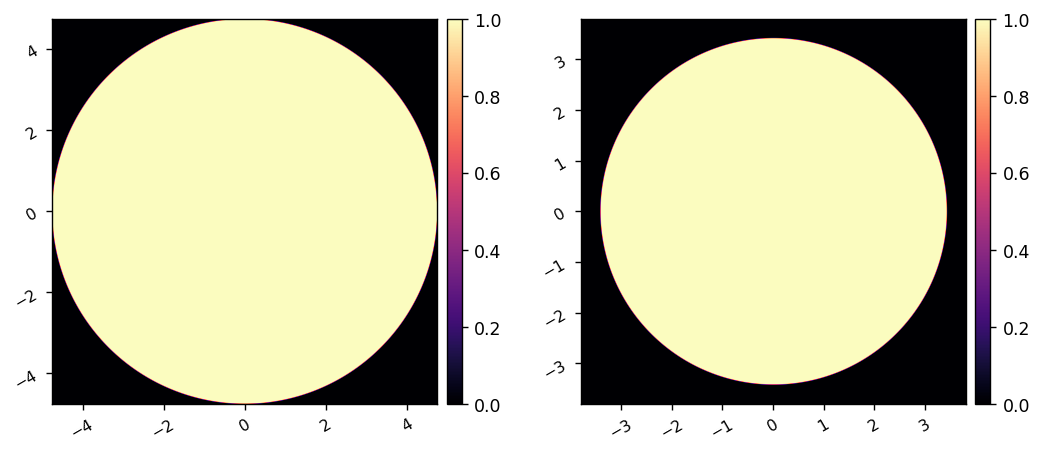

In [8]:
reload(fresnel)
coro = fresnel.CORO()
imshow2(coro.APERTURE.amplitude, coro.LYOT.amplitude, 
        pxscl1=coro.APERTURE.pixelscale.to(u.mm/u.pix), pxscl2=coro.LYOT.pixelscale.to(u.mm/u.pix))

psf = coro.snap()
# coro.Imax_ref = xp.max(psf)

# ref_psf = coro.snap()
# ref_im = coro.snap()

# imshow2(ref_psf, ref_im, 'Fresnel PSF', 'Fresnel Image with VVC', pxscl=coro.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-9)

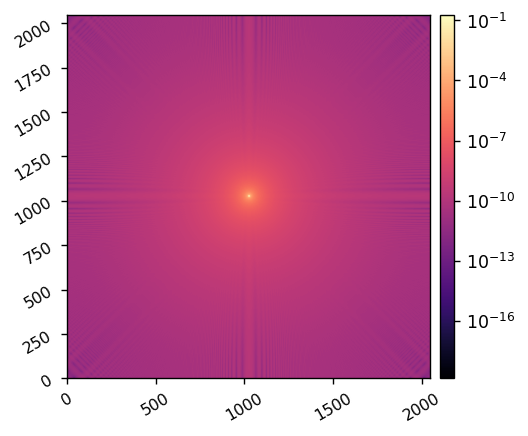

In [10]:
imshow1(psf, lognorm=True, npix)

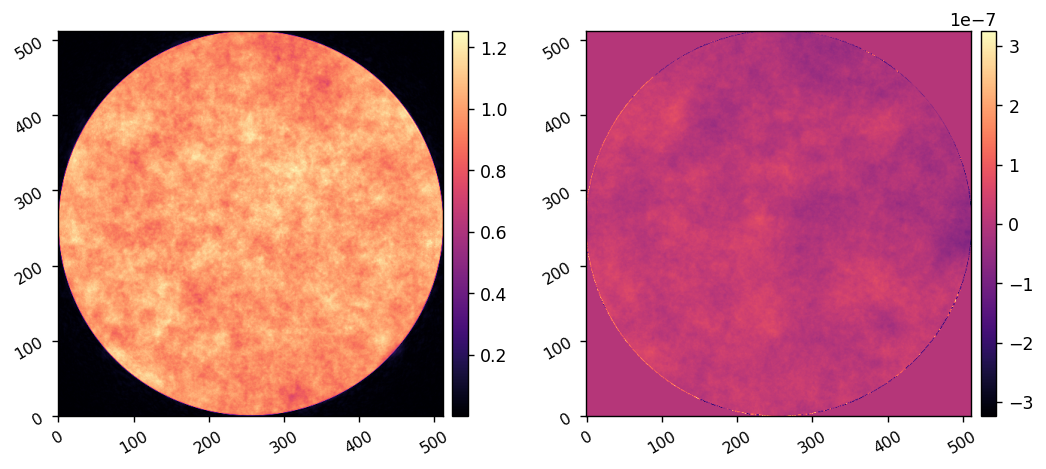

Saved data to:  ../phase-retrieval-data/post_fpm_wfe_20240118.fits


In [4]:
wf_index = 16
amp = apra_pop_models.utils.pad_or_crop(wfs[wf_index].amplitude, coro.npix)
opd = apra_pop_models.utils.pad_or_crop(wfs[wf_index].phase * coro.wavelength.to_value(u.m)/(2*np.pi), coro.npix)
opd *= coro.pupil_mask
imshow2(amp, opd)
wfe = xp.array([amp,opd])

apra_pop_models.utils.save_fits('../phase-retrieval-data/post_fpm_wfe_20240118.fits', 
                                wfe,
                                header={'PIXELSCL':coro.pupil_diam.to_value(u.m)/coro.npix})


In [12]:
coro.lyot_diam

<Quantity 6.5 mm>

In [ ]:
for i,wf in enumerate(wfs[:-1]):
    if 'FPM' in wf.location:
        npix=128
    elif 'Lyot' in wf.location:
        npix=coro.npix
    else:
        npix=coro.npix
    print(wf.w_0, wf.z_r)
    imshow2(wf.amplitude, wf.phase, f'{i:d}, '+wf.location, 
            npix=npix, pxscl=wf.pixelscale.to(u.mm/u.pix),
            cmap1='magma', cmap2='twilight')

imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True, pxscl=coro.psf_pixelscale_lamD, cmap2='twilight')